# Analysis of China's Belt and Road Initiative 

This notebook covers:

- the collection of data and sources
- Processing of data
- attempting to find correlations 

In [2]:
import pandas as pd
import numpy as np
import requests
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup

# Setup Selenium with Chrome WebDriver
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')

# Create a new browser instance
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)


C:\Users\charl\AppData\Local\Temp\ipykernel_14924\1463361557.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Section 1: Collecting Data


webscraping project data from CFR(Council on Foreign Relations) 

In [3]:
url = "https://www.cfr.org/backgrounder/chinas-massive-belt-and-road-initiative#chapter-title-0-5"
driver.get(url)

# Retrieve the page source after JavaScript has executed
html_content = driver.page_source

driver.quit()

In [4]:
soup = BeautifulSoup(html_content, "html.parser")

In [5]:
tables = soup.find_all("table")

if tables:
    print(f"Found {len(tables)} tables on the page.")
else:
    print("No tables were found on the page.")
    
for idx, table in enumerate(tables):
    headers = []
    header_row = table.find("tr")
    if header_row:
        headers = [th.text.strip() for th in header_row.find_all("th")]

    # Extract data from each row
    data = []
    rows = table.find_all("tr")
    for row in rows:
        cols = row.find_all("td")
        if cols:
            data.append([col.text.strip() for col in cols])

    if not headers:
        num_columns = max(len(row) for row in data) if data else 0
        headers = [f"Column {i+1}" for i in range(num_columns)]

    df = pd.DataFrame(data, columns=headers)
    
    csv_filename = f"table_{idx+1}.csv"
    #df.to_csv(csv_filename, index=False)
    print(f"Saved table {idx+1} to {csv_filename}")


Found 4 tables on the page.
Saved table 1 to table_1.csv
Saved table 2 to table_2.csv
Saved table 3 to table_3.csv
Saved table 4 to table_4.csv


I have renamed the csv files to be more relevant and gotten rid of the 2 irrelevant tables manually

In [6]:
df_ICJ = pd.read_csv("IncomeClassificationAndJoin.csv")
df_PD = pd.read_csv("ProjectData.csv")
df_PD.head()

,Year,Location,Country,Region,Type,Amount,Lender,Description
0,2020,"Muzaffarabad, Azad Jammu & Kashmir",Pakistan,South Asia,Hydropower,$2.4B,CDB,Kohala Hydropower Project
1,2020,"Thar, Sindh",Pakistan,South Asia,Coal,$1.9B,ICBC,SSRL Thar Coal Block-I 6.8 mtpa & Power Plant(...
2,2020,Preah Sihanouk,Cambodia,Southeast Asia,Coal,$600M,Chinese banks (China); Royal Group (Cambodia),Sihanoukville CIIDG Power Station 2
3,2019,"Matiari, Sindh to Lahore, Punjab",Pakistan,South Asia,Power Transmission Line,$1.7B,Private sector investors (but built and operat...,Matiari to Lahore ±660kV HVDC Transmission Lin...
4,2019,Adana province,Turkey,Europe/Central Asia,Coal,$1.4B,CDB,"Hunutlu Thermal Power Plant Project with ICBC,..."


In [7]:
df_ICJ.head()

,Country,Region,Income group,Year joined
0,Afghanistan,South Asia,Low income,2013
1,Albania,Europe & Central Asia,Upper middle income,2017
2,Algeria,Middle East & North Africa,Upper middle income,2018
3,Angola,Sub-Saharan Africa,Lower middle income,2018
4,Antigua and Barbuda,Latin America & Caribbean,High income,2018


Filter Data to Low Income countries for the focus of this report

In [8]:
df_ICJ_LI = df_ICJ[(df_ICJ["Income group"] == "Low income") | (df_ICJ["Income group"] == "Lower middle income")]
df_ICJ_LI

,Country,Region,Income group,Year joined
0,Afghanistan,South Asia,Low income,2013
3,Angola,Sub-Saharan Africa,Lower middle income,2018
10,Bangladesh,South Asia,Lower middle income,2019
13,Benin,Sub-Saharan Africa,Low income,Unknown
14,Bolivia,Latin America & Caribbean,Lower middle income,2018
...,...,...,...,...
141,Vanuatu,East Asia & Pacific,Lower middle income,2018
143,Vietnam,East Asia & Pacific,Lower middle income,2017
144,Yemen,Middle East & North Africa,Low income,2017
145,Zambia,Sub-Saharan Africa,Lower middle income,2018


In [9]:
df_ICJ_LI['Year joined'].replace('Unknown','2013', inplace=True)

C:\Users\charl\AppData\Local\Temp\ipykernel_14924\1532978493.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_ICJ_LI['Year joined'].replace('Unknown','2013', inplace=True)
C:\Users\charl\AppData\Local\Temp\ipykernel_14924\1532978493.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ICJ_LI['Year joined'].replace('Unknown','2013', inp

Leaves us with 70 countries in which to focus analysis, Next we will obtain sovereign debt information and information on defaults:
    This will also be done by webscraping debt statistics from the world bank extracting GNI and total debt

## WARNING: This takes a while to run as it is parsing a HUGE amount of data, csv should already be included so no need to run !!

In [10]:
base_url = "https://www.worldbank.org/en/programs/debt-statistics/ids"


response = requests.get(base_url)
soup = BeautifulSoup(response.content, "html.parser")


country_links = []


for link in soup.find_all("a", href=True):
    href = link['href']
    # Check if the link is related to country debt tables
    if "debt" in href and "countryanalytical" in href:
        # Create the full URL if the href is relative
        full_url = href if href.startswith("http") else f"https://www.worldbank.org{href}"
        # Use the link text as the full country name
        country_name = link.get_text(strip=True)
        country_links.append((full_url, country_name))

data = []

# Iterate through each country's URL and name
for country_url, country_name in country_links:
    country_response = requests.get(country_url)
    country_soup = BeautifulSoup(country_response.content, "html.parser")
    
    # Find all tables on the country page
    tables = country_soup.find_all("table")
    
    for table in tables:
        
        headers = [th.get_text(strip=True) for th in table.find_all("th")]
        
        for row in table.find_all("tr"):
            cells = row.find_all("td")
            if len(cells) > 0: 
                row_label = cells[0].get_text(strip=True)  # Assume the first cell is the row label
                
                # Check for the desired rows
                if row_label in ["Gross national income (GNI)", "Total External debt stocks"]:
                    # Extract all columns for the row
                    row_data = [cell.get_text(strip=True) for cell in cells]
                    
                    # If headers are available, use them as column names
                    if headers:
                        row_dict = dict(zip(headers, row_data))
                    else:
                        row_dict = {f"Column_{i}": val for i, val in enumerate(row_data)}
                    
                    # Add country information
                    row_dict['Country'] = country_name
                    data.append(row_dict)
df = pd.DataFrame(data)
#df.to_csv("worldbank_debt_data.csv", index=False)


Clean dataframe:

In [11]:
headers = ['Statistic', '2012', '2013','2014','2015','2016','2017','2018','2019','2020','2021','2022','Country']
df.columns = headers
df.head()

,Statistic,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,Country
0,Total External debt stocks,"2,580.6","2,587.8","2,529.9","2,596.9","2,596.1","2,752.0","2,678.8","2,661.7","3,040.1","3,555.8","3,393.2",Afghanistan
1,Gross national income (GNI),"19,961.3","20,209.4","20,559.7","19,249.5","18,350.5","18,961.8","18,294.5","19,080.7","20,105.2","14,352.6",..,Afghanistan
2,Total External debt stocks,"7,384.5","8,647.0","8,512.5","8,447.0","8,516.2","9,801.5","9,651.1","9,274.5","10,477.4","11,054.9","10,455.0",Albania
3,Gross national income (GNI),"12,228.1","12,996.5","13,349.4","11,521.8","12,053.8","13,051.5","15,138.0","15,200.2","14,912.5","17,681.0","18,569.4",Albania
4,Total External debt stocks,"5,515.7","5,245.6","5,521.2","4,671.4","5,463.0","5,706.8","5,710.5","5,492.4","5,177.9","7,378.8","7,129.3",Algeria


In [12]:
pivot_df = df.pivot(index='Country', columns='Statistic')
pivot_df.head()

2012                             \
Statistic   Gross national income (GNI) Total External debt stocks   
Country                                                              
Afghanistan                    19,961.3                    2,580.6   
Albania                        12,228.1                    7,384.5   
Algeria                       206,411.5                    5,515.7   
Angola                        117,631.2                   36,165.3   
Argentina                     533,073.6                  139,877.7   

                                   2013                             \
Statistic   Gross national income (GNI) Total External debt stocks   
Country                                                              
Afghanistan                    20,209.4                    2,587.8   
Albania                        12,996.5                    8,647.0   
Algeria                       205,600.3                    5,245.6   
Angola                        122,755.6                   43,350.1   
Argentina                     540,185.7                  150,225.0   

                                   2014                             \
Statistic   Gross national income (GNI) Total External debt stocks   
Country                                                              
Afghanistan                    20,559.7                    2,529.9   
Albania                        13,349.4                    8,512.5   
Algeria                       208,874.4                    5,521.2   
Angola                        127,708.8                   45,924.3   
Argentina                     515,532.2                  153,793.8   

                                   2015                             \
Statistic   Gross national income (GNI) Total External debt stocks   
Country                                                              
Afghanistan                    19,249.5                    2,596.9   
Albania                        11,521.8                    8,447.0   
Algeria                       161,667.2                    4,671.4   
Angola                         85,895.4                   48,771.5   
Argentina                     583,615.5                  177,184.6   

                                   2016                             ...  \
Statistic   Gross national income (GNI) Total External debt stocks  ...   
Country                                                             ...   
Afghanistan                    18,350.5                    2,596.1  ...   
Albania                        12,053.8                    8,516.2  ...   
Algeria                       158,474.0                    5,463.0  ...   
Angola                         50,010.1                   57,434.1  ...   
Argentina                     545,251.6                  181,638.5  ...   

                                   2018                             \
Statistic   Gross national income (GNI) Total External debt stocks   
Country                                                              
Afghanistan                    18,294.5                    2,678.8   
Albania                        15,138.0                    9,651.1   
Algeria                       170,507.1                    5,710.5   
Angola                         73,313.1                   61,791.5   
Argentina                     506,094.0                  277,827.1   

                                   2019                             \
Statistic   Gross national income (GNI) Total External debt stocks   
Country                                                              
Afghanistan                    19,080.7                    2,661.7   
Albania                        15,200.2                    9,274.5   
Algeria                       167,561.0                    5,492.4   
Angola                         64,488.2                   62,292.2   
Argentina                     430,166.8                  280,684.8   

                                   2020                             

Calculate the ratio of debt to GNI:

In [13]:
for year in ['2012', '2013','2014','2015','2016','2017','2018','2019','2020','2021','2022']:
    gni = pd.to_numeric(pivot_df[(year, 'Gross national income (GNI)')].str.replace(',', ''), errors='coerce')
    teds = pd.to_numeric(pivot_df[(year, 'Total External debt stocks')].str.replace(',', ''), errors='coerce')
    pivot_df[(year, 'Ratio')] = (teds / gni) 

pivot_df.head()
    

2012                             \
Statistic   Gross national income (GNI) Total External debt stocks   
Country                                                              
Afghanistan                    19,961.3                    2,580.6   
Albania                        12,228.1                    7,384.5   
Algeria                       206,411.5                    5,515.7   
Angola                        117,631.2                   36,165.3   
Argentina                     533,073.6                  139,877.7   

                                   2013                             \
Statistic   Gross national income (GNI) Total External debt stocks   
Country                                                              
Afghanistan                    20,209.4                    2,587.8   
Albania                        12,996.5                    8,647.0   
Algeria                       205,600.3                    5,245.6   
Angola                        122,755.6                   43,350.1   
Argentina                     540,185.7                  150,225.0   

                                   2014                             \
Statistic   Gross national income (GNI) Total External debt stocks   
Country                                                              
Afghanistan                    20,559.7                    2,529.9   
Albania                        13,349.4                    8,512.5   
Algeria                       208,874.4                    5,521.2   
Angola                        127,708.8                   45,924.3   
Argentina                     515,532.2                  153,793.8   

                                   2015                             \
Statistic   Gross national income (GNI) Total External debt stocks   
Country                                                              
Afghanistan                    19,249.5                    2,596.9   
Albania                        11,521.8                    8,447.0   
Algeria                       161,667.2                    4,671.4   
Angola                         85,895.4                   48,771.5   
Argentina                     583,615.5                  177,184.6   

                                   2016                             ...  \
Statistic   Gross national income (GNI) Total External debt stocks  ...   
Country                                                             ...   
Afghanistan                    18,350.5                    2,596.1  ...   
Albania                        12,053.8                    8,516.2  ...   
Algeria                       158,474.0                    5,463.0  ...   
Angola                         50,010.1                   57,434.1  ...   
Argentina                     545,251.6                  181,638.5  ...   

                 2013      2014      2015      2016      2017      2018  \
Statistic       Ratio     Ratio     Ratio     Ratio     Ratio     Ratio   
Country                                                                   
Afghanistan  0.128049  0.123051  0.134907  0.141473  0.145134  0.146427   
Albania      0.665333  0.637669  0.733132  0.706516  0.750986  0.637541   
Algeria      0.025514  0.026433  0.028895  0.034473  0.034058  0.033491   
Angola       0.353142  0.359602  0.567801  1.148450  0.849405  0.842844   
Argentina    0.278099  0.298320  0.303598  0.333128  0.360212  0.548963   

                 2019      2020      2021      2022  
Statistic       Ratio     Ratio     Ratio     Ratio  
Country                                              
Afghanistan  0.139497  0.151210  0.247746       NaN  
Albania      0.610156  0.702592  0.625242  0.563023  
Algeria      0.032779  0.036260  0.045953  0.037337  
Angola       0.965947  1.481196  1.082478  0.608751  
Argentina    0.652502  0.680864  0.515219  0.400037  

[5 rows x 33 columns]

Have now collected all data on Sovreign debt and neccessary BRI statistics.

## All datasets are now collected !! Hooray. Can now begin analysis.. :)

# Section 2 : analysis

Firstly I want to see that if since joining the initiative has the ratio between GNI and Total Debt increased or decreased

In [14]:
def IncDec(Year, Country):
    try:
        data_row = pivot_df.loc[Country]
    except KeyError:
        #print("KeyError, country not contained in data set")
        return np.nan
    start = data_row[(Year, 'Ratio')]
    end = data_row[('2022', 'Ratio')]
    if(np.isnan(end)):
        end = data_row[('2021', 'Ratio')]
    result = end - start
    if (result >= 0):
        return "Increase"
    else:
        return "Decrease"
    
res = IncDec('2013','Afghanistan')
print(res)


Increase


In [15]:
df_ICJ_LI['Debt Increase or Decrease'] = np.nan

C:\Users\charl\AppData\Local\Temp\ipykernel_14924\1403388563.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ICJ_LI['Debt Increase or Decrease'] = np.nan


In [16]:
Number_of_Increased = 0
Number_of_Decreased = 0
for index,row in df_ICJ_LI.iterrows():
    x = IncDec(row['Year joined'],row['Country'])
    df_ICJ_LI.loc[index, 'Debt Increase or Decrease'] = x
    if(x == 'Decrease'):
        Number_of_Decreased+=1
    elif(x == 'Increase'):
        Number_of_Increased+=1

df_ICJ_LI.head()

C:\Users\charl\AppData\Local\Temp\ipykernel_14924\3992814010.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Increase' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_ICJ_LI.loc[index, 'Debt Increase or Decrease'] = x


,Country,Region,Income group,Year joined,Debt Increase or Decrease
0,Afghanistan,South Asia,Low income,2013,Increase
3,Angola,Sub-Saharan Africa,Lower middle income,2018,Decrease
10,Bangladesh,South Asia,Lower middle income,2019,Increase
13,Benin,Sub-Saharan Africa,Low income,2013,Increase
14,Bolivia,Latin America & Caribbean,Lower middle income,2018,Increase


Calculate Total number of Increasing and Decreasing countries:

In [19]:
print("Number of countries with an Increase in Sovereign Debt: ", Number_of_Increased,"Number of countries with a Decrease in Sovereign Debt: ", Number_of_Decreased)

Number of countries with an Increase in Sovereign Debt:  42 Number of countries with a Decrease in Sovereign Debt:  13


### Creating a map to visualise this:

In [17]:
import folium
import json

In [18]:
geojson_url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json'
geojson_data = requests.get(geojson_url).json()  # Get GeoJSON data

m = folium.Map(location=[20, 0], zoom_start=2)

color_map = {
    'Increase': 'red',
    'Decrease': 'green'
}

# Create a feature group for the countries
feature_group = folium.FeatureGroup(name='Debt Status')

# Function to set the style based on country name
def style_function(feature):
    country_name = feature['properties']['name']
    debt_status = df_ICJ_LI.loc[df_ICJ_LI['Country'] == country_name, 'Debt Increase or Decrease']
    
    if not debt_status.empty:  # Check if country exists in the DataFrame
        return {
            'fillColor': color_map.get(debt_status.values[0], 'gray'),
            'color': 'black', #Outline color
            'weight': 0.5,
            'fillOpacity': 0.7
        }
    return {
        'fillColor': 'gray', 
        'color': 'black',
        'weight': 0.5,
        'fillOpacity': 0.7
    }

# Add the GeoJson layer with the style function
feature_group.add_child(folium.GeoJson(
    geojson_data,
    name='Debt Status',
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(fields=['name'], aliases=['Country:'])
))

m.add_child(feature_group)
folium.LayerControl().add_to(m)
m.save('debt_status_map.html')

m


# Will now look at credit defaults, and aim to see if there is a correlation between defaults and the amount borrowed from the chinese government

In [40]:
df_PD_reduced = df_PD

def convert_amount(amount):
    if isinstance(amount, str):
        amount = amount.replace('$', '')
        if 'B' in amount:
            return float(amount.replace('B', '')) * 1e9
        elif 'M' in amount:
            return float(amount.replace('M', '')) * 1e6
    return float(amount) 

df_PD_reduced['Total Loan'] = df_PD_reduced['Amount'].apply(convert_amount)

df_grouped = df_PD_reduced.groupby(['Country', 'Year'])['Total Loan'].sum().reset_index()

pivot_df = df_grouped.pivot(index='Country', columns='Year', values='Total Loan')

pivot_df.fillna(0, inplace=True)

pivot_df.head()


Year,2013,2014,2015,2016,2017,2018,2019,2020
Country,,,,,,,,
Angola,1.300000e+09,2.000000e+09,840000000.0,1.100000e+10,0.0,0.0,0.0,0.0
Bangladesh,1.300000e+08,0.000000e+00,0.0,2.540000e+09,690000000.0,0.0,0.0,0.0
"Benin, Togo",0.000000e+00,0.000000e+00,550000000.0,0.000000e+00,0.0,0.0,0.0,0.0
Bolivia,0.000000e+00,0.000000e+00,0.0,1.000000e+09,0.0,0.0,0.0,0.0
Bosnia & Herzegovina,0.000000e+00,0.000000e+00,0.0,0.000000e+00,880000000.0,0.0,0.0,0.0


Now have the total of project loans for each year. 

In [150]:
import pandas as pd

if ('Additional Details', 'Debt State') not in pivot_df.columns:
    pivot_df[('Additional Details', 'Debt State')] = np.NAN

for row, index in pivot_df.iterrows():
    datapoint = df_ICJ_LI.loc[df_ICJ_LI['Country'] == row, 'Debt Increase or Decrease'].values
    if len(datapoint) > 0:
        pivot_df.at[row, ('Additional Details', 'Debt State')] = datapoint[0]

pivot_df

Year,2013,2014,2015,2016,2017,2018,2019,2020,"(Additional Details, Debt State)"
Country,,,,,,,,,
Angola,1.300000e+09,2.000000e+09,8.400000e+08,1.100000e+10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,Decrease
Bangladesh,1.300000e+08,0.000000e+00,0.000000e+00,2.540000e+09,6.900000e+08,0.000000e+00,0.000000e+00,0.000000e+00,Increase
"Benin, Togo",0.000000e+00,0.000000e+00,5.500000e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,<NA>
Bolivia,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,Increase
Bosnia & Herzegovina,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.800000e+08,0.000000e+00,0.000000e+00,0.000000e+00,<NA>
Cambodia,2.110000e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+08,Increase
Cameroon,0.000000e+00,0.000000e+00,0.000000e+00,2.900000e+08,1.400000e+08,0.000000e+00,0.000000e+00,0.000000e+00,Increase
Cote d'Ivoire,4.900000e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,<NA>
Cuba,0.000000e+00,0.000000e+00,6.000000e+07,0.000000e+00,6.000000e+07,0.000000e+00,0.000000e+00,0.000000e+00,<NA>


In [124]:
import matplotlib.pyplot as plt
import seaborn as sns

Plotting Energy infrastructure project loans over time series 2013-2020

In [156]:
pivot_df[('Additional Details', 'Debt State')] = pivot_df[('Additional Details', 'Debt State')].replace(np.NAN, "None")

In [159]:
series_inc = []
series_dec = []
x = ['2013','2014','2015','2016','2017','2018','2019','2020']
countries_inc = []
countries_dec = []

for index, row in pivot_df.iterrows():
    y = []
    for i in x:
        y.append(row.loc[int(i)])
    debt_state = row[('Additional Details', 'Debt State')]
    if(debt_state == "Increase"):
        series_inc.append(y)
        countries_inc.append(index)
    else:
        series_dec.append(y) 
        countries_dec.append(index)


# we want the total taken in loans over time so need to adjust the series array arrays accordingly

In [160]:
def sumFunc(x):
    for i in range(0, len(x)):
        if(i>0):
            x[i] = x[i] + x[i-1]
    return x

In [161]:
for i in range(0, len(series_inc)):
    series_inc[i] = sumFunc(series_inc[i])

print(series_inc)

for i in range(0, len(series_dec)):
    series_dec[i] = sumFunc(series_dec[i])

print(series_dec)

[[130000000.0, 130000000.0, 130000000.0, 2670000000.0, 3360000000.0, 3360000000.0, 3360000000.0, 3360000000.0], [0.0, 0.0, 0.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0], [2110000000.0, 2110000000.0, 2110000000.0, 2110000000.0, 2110000000.0, 2110000000.0, 2110000000.0, 2710000000.0], [0.0, 0.0, 0.0, 290000000.0, 430000000.0, 430000000.0, 430000000.0, 430000000.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1200000000.0, 2010000000.0, 2010000000.0], [0.0, 0.0, 0.0, 0.0, 140000000.0, 140000000.0, 140000000.0, 140000000.0], [0.0, 0.0, 0.0, 0.0, 0.0, 70000000.0, 70000000.0, 70000000.0], [0.0, 0.0, 0.0, 0.0, 0.0, 200000000.0, 200000000.0, 200000000.0], [420000000.0, 519000000.0, 519000000.0, 519000000.0, 519000000.0, 519000000.0, 519000000.0, 519000000.0], [0.0, 300000000.0, 300000000.0, 300000000.0, 300000000.0, 300000000.0, 300000000.0, 300000000.0], [0.0, 0.0, 250000000.0, 250000000.0, 250000000.0, 250000000.0, 250000000.0, 250000000.0], [0.0, 170000000.0, 170000000.0, 1700000

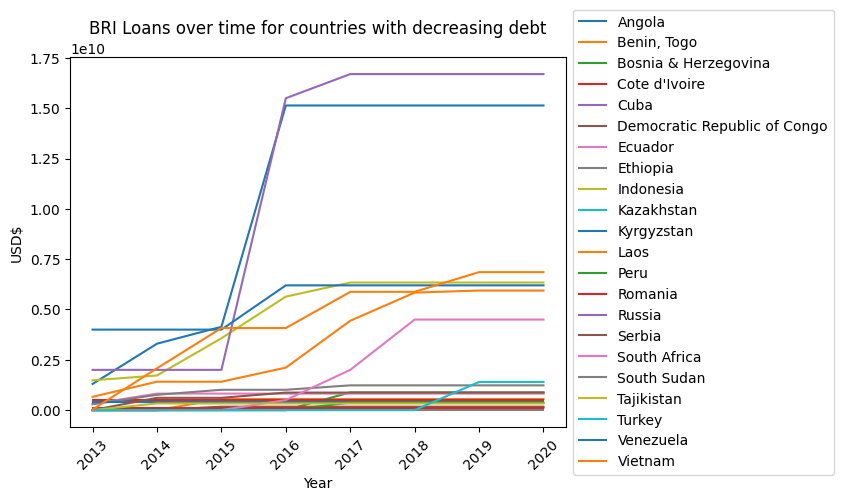

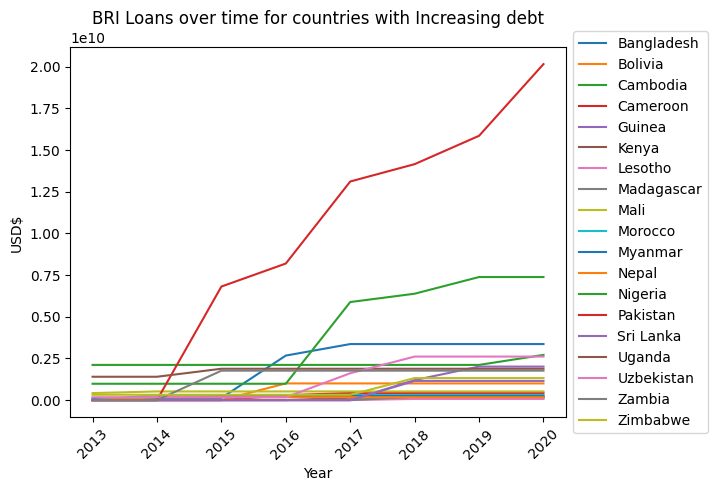

In [164]:
i=0
for value in series_dec:
    plt.plot(x, value, label = countries_dec[i])
    i= i+1

plt.xlabel('Year')
plt.ylabel('USD$')
plt.title('BRI Loans over time for countries with decreasing debt')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45)
#plt.tight_layout()
plt.show()

i=0
for value in series_inc:
    plt.plot(x, value, label = countries_inc[i])
    i= i+1

plt.xlabel('Year')
plt.ylabel('USD$')
plt.title('BRI Loans over time for countries with Increasing debt')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45)
#plt.tight_layout()
plt.show()

#### Thank you for reading :) !! I would love to do more work like this and/ or continue this as I believe it was quite a shallow data analysis